# Mitron Bank Data

## Regression

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
dims_df= pd.read_csv('dim_customers.csv')

In [3]:
dims_df.sample(3)

,customer_id,age_group,city,occupation,gender,marital status,avg_income
2265,ATQCUS2988,45+,Mumbai,Salaried Other Employees,Female,Married,47352
320,ATQCUS0881,25-34,Hyderabad,Government Employees,Male,Married,55061
1494,ATQCUS3885,21-24,Chennai,Freelancers,Female,Single,28009


In [4]:
fact_df= pd.read_csv('fact_spends.csv')

In [5]:
fact_df.sample(3)

,customer_id,month,category,payment_type,spend
67434,ATQCUS3085,July,Groceries,Net Banking,210
502398,ATQCUS3863,June,Travel,Net Banking,46
757662,ATQCUS1344,June,Food,Credit Card,769


#### Merging the DataFrames

In [6]:
merged_df = pd.merge(left=dims_df,right=fact_df,on='customer_id')

In [7]:
merged_df.sample(5)

,customer_id,age_group,city,occupation,gender,marital status,avg_income,month,category,payment_type,spend
741657,ATQCUS1123,35-45,Delhi NCR,Salaried Other Employees,Male,Married,41493,June,Health & Wellness,UPI,516
229418,ATQCUS1932,45+,Chennai,Business Owners,Male,Married,80511,May,Groceries,Net Banking,358
578271,ATQCUS3866,21-24,Bengaluru,Government Employees,Female,Single,41018,June,Apparel,Credit Card,1026
222427,ATQCUS2302,25-34,Bengaluru,Salaried Other Employees,Female,Married,38605,October,Bills,Credit Card,1773
137819,ATQCUS3243,21-24,Mumbai,Government Employees,Male,Single,39415,October,Food,Credit Card,607


In [8]:
merged_df.dtypes

customer_id       object
age_group         object
city              object
occupation        object
gender            object
marital status    object
avg_income         int64
month             object
category          object
payment_type      object
spend              int64
dtype: object

#### **Dropping Customer ID & Month Column**

In [9]:
merged_df.drop(columns=['customer_id','month'],inplace=True)

### **Train-Test Split**

In [14]:
merged_df.shape

(864000, 9)

In [15]:
X = merged_df.drop(columns='spend')
y = merged_df['spend']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=31)

In [17]:
X_train.shape,y_train.shape , X_test.shape,y_test.shape

((604800, 8), (604800,), (259200, 8), (259200,))

### **Encoding Categorical Features**
#### **Using One-Hot Encoding**

In [18]:
ohe = OneHotEncoder(drop='first',sparse=False,dtype=np.int32)

In [19]:
X_train_new = ohe.fit_transform(X_train[['age_group','city','occupation','gender','marital status','category','payment_type']])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
X_train_new
# Contains Only Categorical Encoded Values

array([[0, 1, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int32)

In [21]:
X_train_new.shape

(604800, 24)

**Applying same transfomation on Test data**

In [22]:
X_test_new = ohe.fit_transform(X_test[['age_group','city','occupation','gender','marital status','category','payment_type']])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**Combining Encoded categorical and Numerical values of X_train and X_test**

In [23]:
ohe_X_train = np.hstack((X_train[['avg_income']].values,X_train_new))

In [24]:
ohe_X_test = np.hstack((X_test[['avg_income']].values,X_test_new))

In [25]:
type(ohe_X_train)

numpy.ndarray

In [47]:
ohe_X_train

array([[35532,     0,     1, ...,     0,     1,     0],
       [60041,     1,     0, ...,     1,     0,     0],
       [27794,     0,     0, ...,     0,     0,     0],
       ...,
       [35099,     1,     0, ...,     0,     1,     0],
       [46729,     0,     0, ...,     0,     0,     1],
       [26316,     0,     0, ...,     1,     0,     0]])

### **Scaling**

In [26]:
scaler = StandardScaler()

# Fitting and Transforming the X data 
scaled_ohe_X_train = scaler.fit_transform(ohe_X_train)
scaled_ohe_X_test = scaler.transform(ohe_X_test)

### **Linear Regression**

In [27]:
linear_model = LinearRegression()

In [43]:
linear_model.fit(scaled_ohe_X_train,y_train)

LinearRegression()

In [44]:
print('\033[1m\033[4m\033[95mLinear Model Results\033[0m')
print('R2 score for Train data is ', linear_model.score(scaled_ohe_X_train,y_train))
print('R2 score for Test data is ', r2_score(y_test,linear_model.predict(scaled_ohe_X_test)))
print('Mean Absolute Error is ',mean_absolute_error(y_test,linear_model.predict(scaled_ohe_X_test)))
print('Mean Squared Error is ',np.sqrt(mean_squared_error(y_test,linear_model.predict(scaled_ohe_X_test))))

Linear Model Results
R2 score for Train data is  0.47734091192030226
R2 score for Test data is  0.47946616183954005
Mean Absolute Error is  318.15623765168414
Mean Squared Error is  479.68386055105907


### **XG Boost Regressor**

In [33]:
xgb_model.fit(scaled_ohe_X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
print('\033[1m\033[4m\033[95mXG Boost Model Results\033[0m')
print('R2 score for Train data is ', xgb_model.score(scaled_ohe_X_train,y_train))
print('R2 score for Test data is ', r2_score(y_test,xgb_model.predict(scaled_ohe_X_test)))
print('Mean Absolute Error is ',mean_absolute_error(y_test,xgb_model.predict(scaled_ohe_X_test)))
print('Mean Squared Error is ',np.sqrt(mean_squared_error(y_test,xgb_model.predict(scaled_ohe_X_test))))

XG Boost Model Results
R2 score for Train data is  0.8678482797540568
R2 score for Test data is  0.8674684524230976
Mean Absolute Error is  142.11990426498684
Mean Squared Error is  242.04173516738285


### **Outlier Analysis**

In [10]:
columns_to_check = ['avg_income', 'spend']

# Calculate Z-scores for selected columns
z_scores = zscore(merged_df[columns_to_check])

# Set a threshold for Z-scores (e.g., 3 or -3, depending on your preference)
z_score_threshold = 3

# Identify outliers based on the Z-score
outliers = (abs(z_scores) > z_score_threshold).any(axis=1)

# Display rows with outliers
outlier_rows = merged_df[outliers]
print("Rows with outliers:")
print(outlier_rows)

# Display summary statistics for columns to check
print("\nSummary statistics for selected columns:")
print(merged_df[columns_to_check].describe())

Rows with outliers:
       age_group       city             occupation gender marital status  \
2            45+  Bengaluru  Salaried IT Employees   Male        Married   
19           45+  Bengaluru  Salaried IT Employees   Male        Married   
58           45+  Bengaluru  Salaried IT Employees   Male        Married   
80           45+  Bengaluru  Salaried IT Employees   Male        Married   
182          45+  Bengaluru  Salaried IT Employees   Male        Married   
...          ...        ...                    ...    ...            ...   
863879     25-34     Mumbai        Business Owners   Male         Single   
863886     25-34     Mumbai        Business Owners   Male         Single   
863912     25-34     Mumbai        Business Owners   Male         Single   
863923     25-34     Mumbai        Business Owners   Male         Single   
863936     25-34     Mumbai        Business Owners   Male         Single   

        avg_income     category payment_type  spend  
2            

In [11]:
# Remove outliers from the DataFrame
filtered_df = merged_df[~outliers]

# Display summary statistics for the filtered DataFrame
print("\nSummary statistics for filtered DataFrame:")
filtered_df[columns_to_check].describe()


Summary statistics for filtered DataFrame:


,avg_income,spend
count,846094.000000,846094.000000
mean,51409.300686,553.961627
std,14691.743884,503.800582
min,24816.000000,6.000000
25%,38560.000000,188.000000
50%,49893.000000,385.000000
75%,64610.000000,756.000000
max,86600.000000,2599.000000


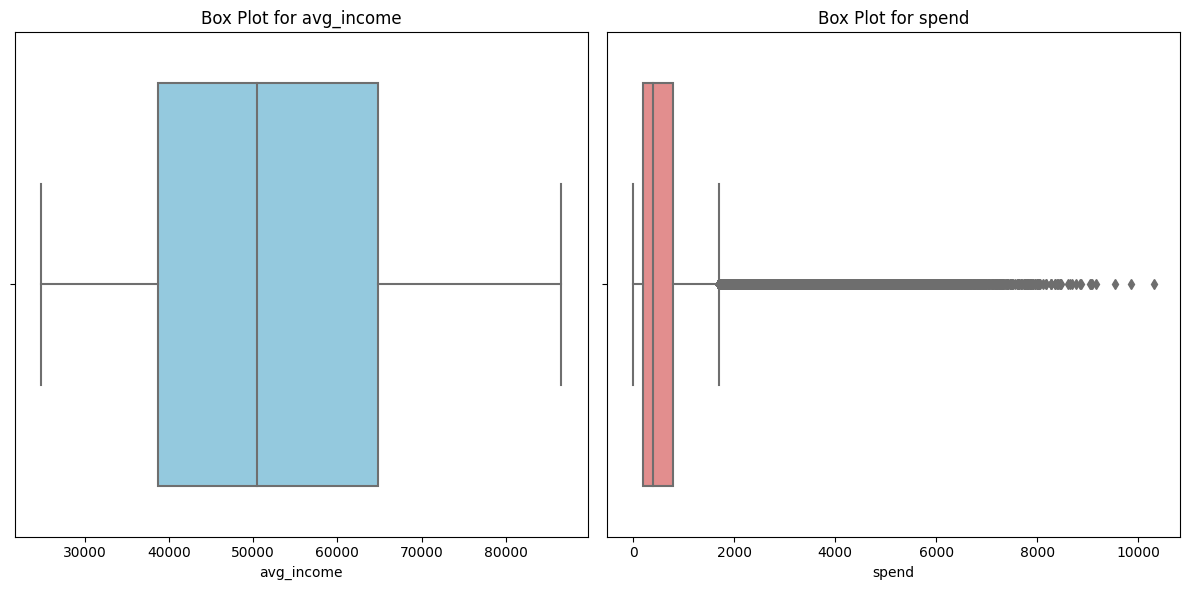

In [12]:
# Create subplots for each column
plt.figure(figsize=(12, 6))

# Box plot for 'avg_income'
plt.subplot(1, 2, 1)
sns.boxplot(x='avg_income', data=merged_df, color='skyblue')
plt.title('Box Plot for avg_income')

# Box plot for 'spend'
plt.subplot(1, 2, 2)
sns.boxplot(x='spend', data=merged_df, color='lightcoral')
plt.title('Box Plot for spend')

# Show the plot
plt.tight_layout()
plt.show()

* From above Box Plots, we can say that there are More Outliers in the Spend Column

### **Log Transforming the Spend column**

In [13]:
# Log-transform the 'spend' column
merged_df['spend_log'] = np.log1p(merged_df['spend'])

#### **Train-Test Split for Log Transformed Data**

In [14]:
X = merged_df[['age_group', 'city', 'occupation', 'gender', 'marital status', 'avg_income', 'category', 'payment_type']]
y = merged_df['spend_log']

In [15]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.30, random_state=31)

In [16]:
ohe2 = OneHotEncoder(drop='first',sparse=False,dtype=np.int32)

X_train_new2 = ohe2.fit_transform(X_train2[['age_group','city','occupation','gender','marital status','category','payment_type']])

X_test_new2 = ohe2.fit_transform(X_test2[['age_group','city','occupation','gender','marital status','category','payment_type']])

ohe_X_train2 = np.hstack((X_train2[['avg_income']].values,X_train_new2))

ohe_X_test2 = np.hstack((X_test2[['avg_income']].values,X_test_new2))

In [17]:
scaler2 = StandardScaler()

# Fitting and Transforming the X data 
scaled_ohe_X_train2 = scaler2.fit_transform(ohe_X_train2)
scaled_ohe_X_test2 = scaler2.transform(ohe_X_test2)

#### **XG Boost Model 2**

In [18]:
xgb_model2 = XGBRegressor()
xgb_model2.fit(scaled_ohe_X_train2,y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
print('\033[1m\033[4m\033[95mXG Boost Model Results\033[0m')
print('R2 score for Train data is ', xgb_model2.score(scaled_ohe_X_train2,y_train2))
print('R2 score for Test data is ', r2_score(y_test2,xgb_model2.predict(scaled_ohe_X_test2)))
print('Mean Absolute Error is ',mean_absolute_error(y_test2,xgb_model2.predict(scaled_ohe_X_test2)))
print('Mean Squared Error is ',np.sqrt(mean_squared_error(y_test2,xgb_model2.predict(scaled_ohe_X_test2))))

XG Boost Model Results
R2 score for Train data is  0.9166499524613672
R2 score for Test data is  0.9163785777993315
Mean Absolute Error is  0.23210309241154853
Mean Squared Error is  0.29151531921077406


### **Making a Prediction**

Our inputs should be in the **Order of 'avg_income','age_group','city','occupation','gender','marital status','category','payment_type'**

#### **Sample Test with XG Boost Model 2**

**Test 1**

In [22]:
# with 2nd Model
data = [32602,'21-24','Mumbai','Salaried Other Employees','Female','Single','Others','Net Banking']

input_data =np.hstack(([[data[0]]],
                       ohe2.transform([[ data[1],data[2],data[3],data[4],data[5],data[6],data[7] ]])
                      ))

scaled_input_data = scaler2.transform(input_data)

xgb_model2.predict(scaled_input_data)
np.expm1(xgb_model2.predict(scaled_input_data))

array([37.762722], dtype=float32)

**Test 2**

In [24]:
# with 2nd Model
data = [70026,'25-34','Mumbai','Business Owners','Male','Married','Food','UPI']

input_data =np.hstack(([[data[0]]],
                       ohe2.transform([[ data[1],data[2],data[3],data[4],data[5],data[6],data[7] ]])
                      ))

scaled_input_data = scaler2.transform(input_data)

xgb_model2.predict(scaled_input_data)
np.expm1(xgb_model2.predict(scaled_input_data))

array([684.83905], dtype=float32)

**Test 3**

In [26]:
# with 2nd Model
data = [37863,'35-45','Chennai','Freelancers','Male','Single','Bills','Credit Card']

input_data =np.hstack(([[data[0]]],
                       ohe2.transform([[ data[1],data[2],data[3],data[4],data[5],data[6],data[7] ]])
                      ))

scaled_input_data = scaler2.transform(input_data)

xgb_model2.predict(scaled_input_data)
np.expm1(xgb_model2.predict(scaled_input_data))

array([1117.7808], dtype=float32)

### Saving the Model, Encoder, Scaler

In [27]:
import pickle

In [28]:
pickle.dump(xgb_model2,open('mitron_bank_spend_prediction_XGBoost_model.sav','wb'))

In [29]:
pickle.dump(ohe2,open('One_Hot_Encoder.sav','wb'))

In [30]:
pickle.dump(scaler2,open('Scaler.sav','wb'))